In [3]:
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")


def extract_svo(clause):
    doc = nlp(clause)
    subject, verb, obj = "", "", ""

    for token in doc:
        if token.dep_ == "nsubj" and subject == "":
            subject = token.text
        elif token.pos_ == "VERB" and verb == "":
            verb = token.lemma_
        elif token.dep_ in ("dobj", "pobj", "attr") and obj == "":
            obj = token.text

    return subject, verb, obj

df = pd.read_csv("node_embeddings3.csv", on_bad_lines = 'skip')  # adjust path as needed

df[["subject", "verb", "object"]] = df["clause"].apply(lambda text: pd.Series(extract_svo(str(text))))
output_path = "node_embeddings_svo.csv"
df.to_csv(output_path, index=False)
print(f"SVO extraction completed. File saved to {output_path}")

SVO extraction completed. File saved to node_embeddings_svo.csv


In [ ]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")


def extract_svo(clause):
    doc = nlp(clause)
    subject, verb, obj = "", "", ""

    for token in doc:
        if token.dep_ == "nsubj" and subject == "":
            subject = token.text
        elif token.pos_ == "VERB" and verb == "":
            verb = token.lemma_
        elif token.dep_ in ("dobj", "pobj", "attr") and obj == "":
            obj = token.text

    return subject, verb, obj

df = pd.read_csv("node_embeddings_test3.csv", on_bad_lines = 'skip')  # adjust path as needed

df[["subject", "verb", "object"]] = df["clause"].apply(lambda text: pd.Series(extract_svo(str(text))))
output_path = "node_embeddings_svo_test.csv"
df.to_csv(output_path, index=False)
print(f"SVO extraction completed. File saved to {output_path}")

SVO extraction completed. File saved to node_embeddings_svo_test.csv


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import classification_report


df = pd.read_csv("node_embeddings_svo.csv", on_bad_lines='skip')
def parse_embedding(e):
    return list(map(float, e.split(',')))

x = torch.tensor([parse_embedding(e) for e in df['embedding']], dtype=torch.float)

label_map = {'emotion': 0, 'cause': 1, 'neither': 2, 'both': 3}
y = torch.tensor([
    label_map.get(str(l).strip().lower(), 2)  # Default to 'neither' if unknown
    for l in df['emotion_type']
], dtype=torch.long)

edge_index = []
for i, row_i in df.iterrows():
    for j, row_j in df.iterrows():
        if i == j:
            continue
        if row_i['verb'] == row_j['verb']:
            edge_index.append([i, j])
        if row_i['object'] == row_j['subject']:
            edge_index.append([i, j])
edge_index = torch.tensor(edge_index, dtype=torch.long).T

data = Data(x=x, edge_index=edge_index, y=y)

class DyGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(DyGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch import nn
from torch_geometric.nn import GCNConv

def parse_embedding(embedding_str):
    return [float(x) for x in embedding_str.strip("[]").split(',')]

train_df = pd.read_csv("node_embeddings_svo.csv", on_bad_lines='skip')

label_map = {
    "emotion": 0,
    "cause": 1,
    "neither": 2,
    "both": 3
}

x = torch.tensor([parse_embedding(e) for e in train_df['embedding']], dtype=torch.float)
y = torch.tensor([
    label_map.get(str(l).strip().lower(), 2)
    for l in train_df['emotion_type']
], dtype=torch.long)

edge_index = []
for i, row_i in train_df.iterrows():
    for j, row_j in train_df.iterrows():
        if i == j:
            continue
        if row_i['verb'] == row_j['verb']:
            edge_index.append([i, j])
        if row_i['object'] == row_j['subject']:
            edge_index.append([i, j])
edge_index = torch.tensor(edge_index, dtype=torch.long).T

data = Data(x=x, edge_index=edge_index, y=y)

test_df = pd.read_csv("node_embeddings_svo_test.csv", on_bad_lines='skip')
x_test = torch.tensor([parse_embedding(e) for e in test_df['embedding']], dtype=torch.float)
y_test = torch.tensor([
    label_map.get(str(l).strip().lower(), 2)
    for l in test_df['emotion_type']
], dtype=torch.long)

edge_index_test = []
for i, row_i in test_df.iterrows():
    for j, row_j in test_df.iterrows():
        if i == j:
            continue
        if row_i['verb'] == row_j['verb']:
            edge_index_test.append([i, j])
        if row_i['object'] == row_j['subject']:
            edge_index_test.append([i, j])
edge_index_test = torch.tensor(edge_index_test, dtype=torch.long).T

test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
test_data = test_data.to(device)

class DyGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(DyGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.conv2(x, edge_index)
        return x

model = DyGCN(in_channels=x.shape[1], hidden_channels=64, num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y.cpu().numpy()),
    y=y.cpu().numpy()
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    pred = model(test_data).argmax(dim=1)

target_names = ['emotion', 'cause', 'neither', 'both']
print("\nClassification Report:")
print(classification_report(test_data.y.cpu(), pred.cpu(), target_names=target_names))
test_df['predicted_label'] = pred.cpu().numpy()
test_df['predicted_class'] = test_df['predicted_label'].apply(lambda x: target_names[x])
test_df['true_label'] = test_data.y.cpu().numpy()
test_df['true_class'] = test_df['true_label'].apply(lambda x: target_names[x])
test_df.to_csv("test_predictions.csv", index=False)
print("✅ Predictions saved to 'test_predictions.csv'")



Epoch 1, Loss: 1.3896
Epoch 2, Loss: 1.3775
Epoch 3, Loss: 1.3621
Epoch 4, Loss: 1.3523
Epoch 5, Loss: 1.3338
Epoch 6, Loss: 1.3206
Epoch 7, Loss: 1.3071
Epoch 8, Loss: 1.2881
Epoch 9, Loss: 1.2735
Epoch 10, Loss: 1.2655
Epoch 11, Loss: 1.2509
Epoch 12, Loss: 1.2388
Epoch 13, Loss: 1.2323
Epoch 14, Loss: 1.2127
Epoch 15, Loss: 1.2037
Epoch 16, Loss: 1.2023
Epoch 17, Loss: 1.1892
Epoch 18, Loss: 1.1768
Epoch 19, Loss: 1.1780
Epoch 20, Loss: 1.1696
Epoch 21, Loss: 1.1618
Epoch 22, Loss: 1.1443
Epoch 23, Loss: 1.1417
Epoch 24, Loss: 1.1367
Epoch 25, Loss: 1.1272
Epoch 26, Loss: 1.1309
Epoch 27, Loss: 1.1310
Epoch 28, Loss: 1.1185
Epoch 29, Loss: 1.1143
Epoch 30, Loss: 1.1067
Epoch 31, Loss: 1.1014
Epoch 32, Loss: 1.0899
Epoch 33, Loss: 1.0951
Epoch 34, Loss: 1.0833
Epoch 35, Loss: 1.0890
Epoch 36, Loss: 1.0846
Epoch 37, Loss: 1.0798
Epoch 38, Loss: 1.0752
Epoch 39, Loss: 1.0648
Epoch 40, Loss: 1.0688
Epoch 41, Loss: 1.0733
Epoch 42, Loss: 1.0590
Epoch 43, Loss: 1.0723
Epoch 44, Loss: 1.04

In [ ]:
torch.save(model.state_dict(), 'dygcn_emotion_model.pt')


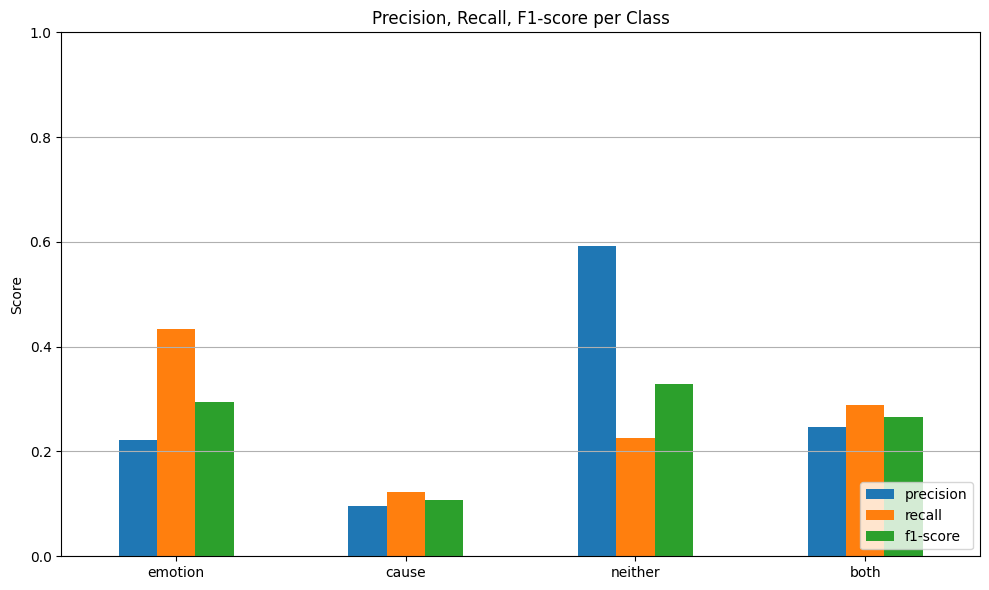

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

report_dict = classification_report(test_data.y.cpu(), pred.cpu(), target_names=['emotion', 'cause', 'neither', 'both'], output_dict=True)
report_df = pd.DataFrame(report_dict).T

class_metrics = report_df.loc[['emotion', 'cause', 'neither', 'both'], ['precision', 'recall', 'f1-score']]
class_metrics.plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
